# Explore here

In [7]:
import pandas as pd
import numpy as np

import os
import shutil
import zipfile
import requests

from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
from keras.src.legacy.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

# Sistema de clasificación de imágenes

El conjunto de datos se compone de fotos de perros y gatos proporcionadas como un subconjunto de fotos de uno mucho más grande de 3 millones de fotos anotadas manualmente. Estos datos se obtuvieron a través de una colaboración entre Petfinder.com y Microsoft.

El conjunto de datos se usó originalmente como un CAPTCHA, es decir, una tarea que se cree que un humano encuentra trivial, pero que una máquina no puede resolver, que se usa en sitios web para distinguir entre usuarios humanos y bots. La tarea se denominó "Asirra". Cuando se presentó "Asirra", se mencionó "que los estudios de usuarios indican que los humanos pueden resolverlo el 99,6% de las veces en menos de 30 segundos". A menos que se produzca un gran avance en la visión artificial, esperamos que los ordenadores no tengan más de 1/54.000 posibilidades de resolverlo.

En el momento en que se publicó la competencia, el resultado de última generación se logró con un SVM y se describió en un artículo de 2007 con el título "Ataques de Machine Learning contra el CAPTCHA de Asirra" (PDF) que logró una precisión de clasificación del 80%. Fue este documento el que demostró que la tarea ya no era una tarea adecuada para un CAPTCHA poco después de que se propusiera la tarea.


# Paso 1: Carga del conjunto de datos

El conjunto de datos se encuentra en este link. Descarga la carpeta y descomprime los archivos. Ahora tendrás una carpeta con el dataset y una carpeta llamada train que contiene más de 25.000 archivos de imagen (formato .jpg) de perros y gatos. Las fotos están etiquetadas por su nombre de archivo, con la palabra dog o cat.
 - 1. Definir la ruta de acceso a las imágenes
 

In [8]:
url = 'https://storage.googleapis.com/datascience-materials/dogs-vs-cats.zip'

response = requests.get(url, stream=True)

with open('../data/raw/dogs-vs-cats.zip', 'wb') as rute:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            rute.write(chunk)
with zipfile.ZipFile('../data/raw/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/interim/')

    

# Paso 2: Visualiza la información de entrada
El primer paso cuando nos enfrentamos a un problema de clasificación de imágenes es obtener toda la información posible a través de ellas. Por lo tanto, carga e imprime las primeras nueve fotos de perros en una sola figura. Repite lo mismo para los gatos. Puedes ver que las fotos son a color y tienen diferentes formas y tamaños.

Esta variedad de tamaños y formatos debe solucionarse antes de entrenar el modelo. Asegúrate de que todas tengan un tamaño fijo de 200x200 píxeles.

Como podrás ver, son una gran cantidad de imágenes, asegúrate de seguir las siguientes normas:

Si tienes más de 12 gigabytes de RAM, usa la API de procesamiento de imágenes de Keras para cargar las 25.000 fotos en el conjunto de datos de entrenamiento y remodelarlas a fotos cuadradas de 200×200 píxeles. La etiqueta también debe determinarse para cada foto en función de los nombres de archivo. Se debe guardar una tupla de fotos y etiquetas.
Si no tienes más de 12 gigabytes de RAM, carga las imágenes progresivamente usando la clase Keras ImageDataGenerator y la función flow_from_directory(). Esto será más lento de ejecutar, pero se ejecutará en hardware de menor capacidad. Esta función prefiere que los datos se dividan en directorios train y test separados, y debajo de cada directorio para tener un subdirectorio para cada clase.
Una vez tengas todas las imágenes procesadas, crea un objeto ImageDataGenerator para datos de entrenamiento y prueba. Luego pasa la carpeta que tiene datos de entrenamiento al objeto trdata y, de manera similar, pasa la carpeta que tiene datos de prueba al objeto tsdata. De esta forma, se etiquetarán las imágenes automáticamente y estará todo listo para entrar a la red.

In [9]:
# --- 1. CONFIGURACIÓN DE RUTAS ---

# RUTA CORRECTA DONDE EL ZIP EXTRAJO LOS ARCHIVOS MEZCLADOS:
SOURCE_DIR_MIXED = '../data/interim/dogs-vs-cats/train/' 

# RUTAS DE DESTINO (Donde Keras va a leer)
BASE_DIR_ORGANIZED = '../data/organized_dataset/' 
TRAIN_DIR = os.path.join(BASE_DIR_ORGANIZED, 'train')
TEST_DIR = os.path.join(BASE_DIR_ORGANIZED, 'test')


# --- 2. CREAR LA ESTRUCTURA DE CARPETAS NECESARIA ---

DIRS_TO_CREATE = [
    os.path.join(TRAIN_DIR, 'dog'), os.path.join(TRAIN_DIR, 'cat'),
    os.path.join(TEST_DIR, 'dog'), os.path.join(TEST_DIR, 'cat')
]
for dir_path in DIRS_TO_CREATE:
    os.makedirs(dir_path, exist_ok=True)
print("✅ 1/3. Estructura de carpetas vacías creada para Keras.")


# --- 3. CLASIFICAR Y MOVER ARCHIVOS ---

try:
    all_files = os.listdir(SOURCE_DIR_MIXED)
    image_files = [f for f in all_files if f.endswith('.jpg') and (f.startswith('cat.') or f.startswith('dog.'))]
except FileNotFoundError:
    print(f"❌ Error: La ruta de origen {SOURCE_DIR_MIXED} no fue encontrada. Revisa la extracción.")
    exit()

np.random.shuffle(image_files)
train_split_index = int(len(image_files) * 0.8) # 80% para entrenamiento

print(f"Total de imágenes a organizar: {len(image_files)}")
print("🔄 2/3. Moviendo y clasificando archivos...")

for i, filename in enumerate(image_files):
    src_path = os.path.join(SOURCE_DIR_MIXED, filename)
    
    # 3a. Determinar destino (Train o Test)
    target_base_dir = TRAIN_DIR if i < train_split_index else TEST_DIR
        
    # 3b. Determinar Subcarpeta (dog o cat)
    if filename.startswith('cat'):
        class_folder = 'cat'
    elif filename.startswith('dog'):
        class_folder = 'dog'
    else:
        continue 

    # Mover el archivo
    dst_path = os.path.join(target_base_dir, class_folder, filename)
    shutil.move(src_path, dst_path)

print("✅ 3/3. Organización completada. Tu dataset está listo.")

✅ 1/3. Estructura de carpetas vacías creada para Keras.
Total de imágenes a organizar: 25000
🔄 2/3. Moviendo y clasificando archivos...
✅ 3/3. Organización completada. Tu dataset está listo.


In [10]:
# --- 1. RUTAS ORGANIZADAS ---
ORGANIZED_BASE_DIR = '../data/organized_dataset/'
TRAIN_DIR = os.path.join(ORGANIZED_BASE_DIR, 'train')
TEST_DIR = os.path.join(ORGANIZED_BASE_DIR, 'test')
DOG_TRAIN_PATH = os.path.join(TRAIN_DIR, 'dog') # Ruta a las imágenes de perros
CAT_TRAIN_PATH = os.path.join(BASE_DIR_ORGANIZED, 'train', 'cat') # Ruta a las imágenes de perros
IMAGE_SIZE = (200, 200)

# --- 2. CARGA DE DATOS EN KERAS ---
print("Cargando datos organizados en Keras...")

# Normalizamos los valores de los píxeles (rescale=1./255)
datagen = ImageDataGenerator(rescale=1./255) 

train_data = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    classes=['dog', 'cat'],
    class_mode='categorical',   
    batch_size=32
)

test_data = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    classes=['dog', 'cat'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)





Cargando datos organizados en Keras...
Found 24800 images belonging to 2 classes.
Found 12197 images belonging to 2 classes.


# Imágenes Perros 

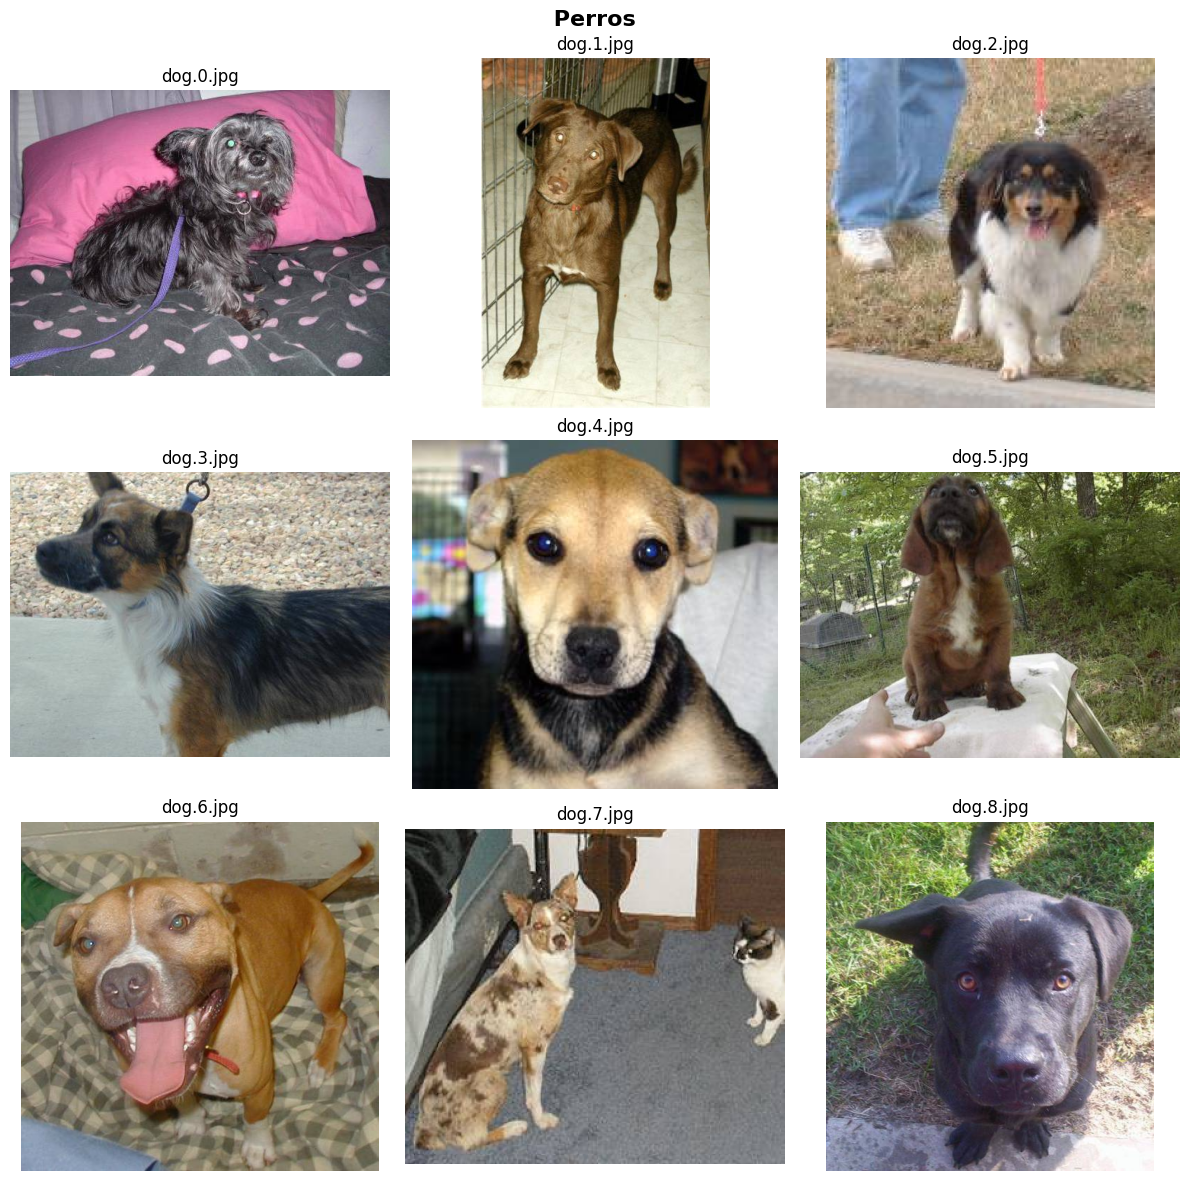

In [11]:
# --- 3. VISUALIZACIÓN DE MUESTRAS (Verificación) ---
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle(' Perros ', fontsize=16, fontweight='bold')

for idx in range(9):
    # Construimos la ruta COMPLETA al archivo
    file_name = f'dog.{idx}.jpg'
    file_path = os.path.join(DOG_TRAIN_PATH, file_name)
    
    row = idx // 3
    col = idx % 3
    
    try:
        img = Image.open(file_path) 
        axes[row, col].imshow(img)
        axes[row, col].set_title(file_name)
        axes[row, col].axis('off')
        
    except FileNotFoundError:
        axes[row, col].set_title(f'{file_name} NO ENCONTRADO')
        axes[row, col].axis('off')
        
plt.tight_layout()
plt.show()

# Imágenes Gatos 


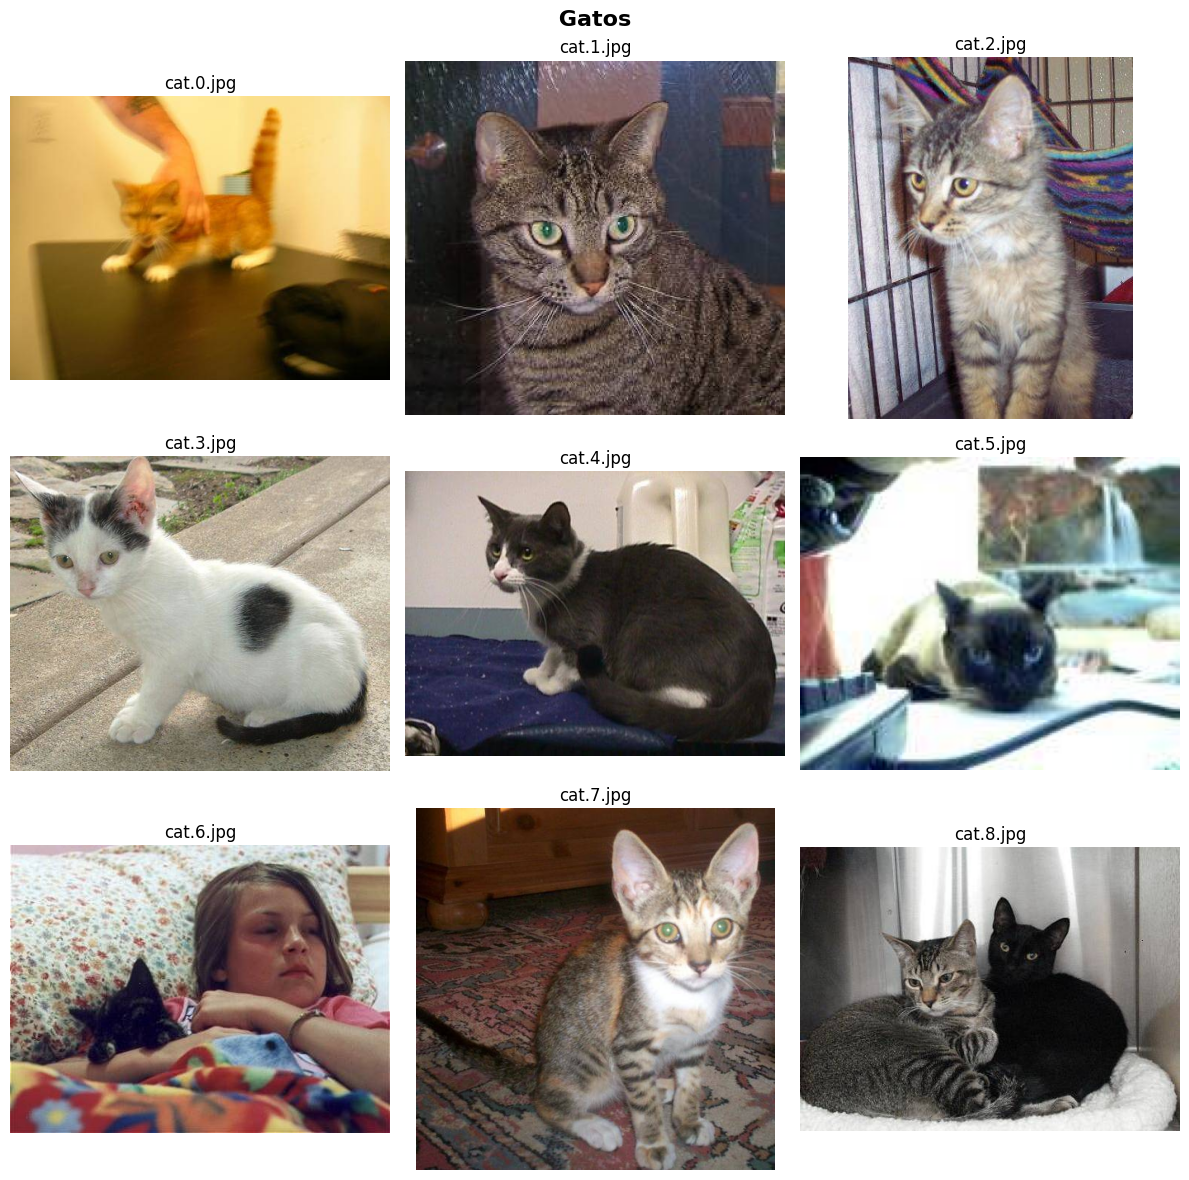

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle(' Gatos ', fontsize=16, fontweight='bold')

for idx in range(9):
    # Construimos la ruta COMPLETA al archivo
    file_name = f'cat.{idx}.jpg'
    file_path = os.path.join(CAT_TRAIN_PATH, file_name)
    
    row = idx // 3
    col = idx % 3
    
    try:
        img = Image.open(file_path) 
        axes[row, col].imshow(img)
        axes[row, col].set_title(file_name)
        axes[row, col].axis('off')
        
    except FileNotFoundError:
        axes[row, col].set_title(f'{file_name} NO ENCONTRADO')
        axes[row, col].axis('off')
        
plt.tight_layout()
plt.show()

# Entrenar Modelo 

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout


simplified_model = Sequential()


simplified_model.add(Conv2D(input_shape=(200,200,3), filters=32, kernel_size=(3,3), activation="relu"))
simplified_model.add(MaxPool2D(pool_size=(2,2)))


simplified_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
simplified_model.add(MaxPool2D(pool_size=(2,2)))
simplified_model.add(Dropout(0.25)) # Añadimos Dropout para regularización


simplified_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
simplified_model.add(MaxPool2D(pool_size=(2,2)))
simplified_model.add(Dropout(0.25))

simplified_model.add(Flatten()) # De 3D a 1D
simplified_model.add(Dense(units=512, activation="relu")) # Reducimos 4096 a 512
simplified_model.add(Dropout(0.5)) # Fuerte Dropout para evitar memorización
simplified_model.add(Dense(units=2, activation="softmax")) # Salida: 2 clases

# Ajustar el Modelo 
 - modelo necesita saber cómo medir su rendimiento y cómo ajustarse:

In [14]:
from keras.optimizers import Adam
simplified_model.compile(loss = keras.losses.categorical_crossentropy, optimizer = Adam(learning_rate = 0.001), metrics = ["accuracy"])
print("✅ Modelo ajustado correctamente. Listo para entrenar.")

✅ Modelo ajustado correctamente. Listo para entrenar.


# Entrenamiento del modelo 

In [21]:
train_model= simplified_model.fit(train_data, epochs = 1)

775/775 ━━━━━━━━━━━━━━━━━━━━ 1312s 2s/step - accuracy: 0.7404 - loss: 0.5256


In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Usaremos un nombre de archivo más general para el modelo simplificado
checkpoint = ModelCheckpoint(
    "../models/best_simplified_model.keras", 
    monitor = "val_accuracy", 
    verbose = 1, 
    save_best_only = True, 
    mode = "max"
)

early = EarlyStopping(
    monitor = "val_accuracy", 
    patience = 3, # Espera 3 épocas sin mejora
    verbose = 1, 
    mode = "max"
)

# --- EJECUTAR ENTRENAMIENTO ---
# Usamos 'simplified_model' en lugar de 'model' y guardamos el historial en 'hist'
hist = simplified_model.fit(
    train_data, 
    steps_per_epoch = 100, 
    validation_data = test_data, 
    validation_steps = 10, 
    epochs = 10, # Usaremos 10 épocas, pero EarlyStopping lo detendrá antes si es necesario
    callbacks = [checkpoint, early]
)

print("✅ Entrenamiento iniciado con éxito. El historial está guardado en 'hist'.")

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7988 - loss: 0.4460
Epoch 1: val_accuracy improved from None to 0.78438, saving model to ../models/best_simplified_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.7894 - loss: 0.4575 - val_accuracy: 0.7844 - val_loss: 0.4387
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8020 - loss: 0.4382
Epoch 2: val_accuracy improved from 0.78438 to 0.84062, saving model to ../models/best_simplified_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8000 - loss: 0.4341 - val_accuracy: 0.8406 - val_loss: 0.3816
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8007 - loss: 0.4226
Epoch 3: val_accuracy improved from 0.84062 to 0.84688, saving model to ../models/best_simplified_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8059 - loss: 0.4272 - val_accuracy: 0.8469 - val_loss: 0.3132
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0

c:\Users\ANTONIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.90938
100/100 ━━━━━━━━━━━━━━━━━━━━ 4846s 49s/step - accuracy: 0.8200 - loss: 0.3931 - val_accuracy: 0.8438 - val_loss: 0.3146
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8456 - loss: 0.3705
Epoch 9: val_accuracy did not improve from 0.90938
100/100 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8406 - loss: 0.3688 - val_accuracy: 0.8813 - val_loss: 0.2733
Epoch 9: early stopping
✅ Entrenamiento iniciado con éxito. El historial está guardado en 'hist'.


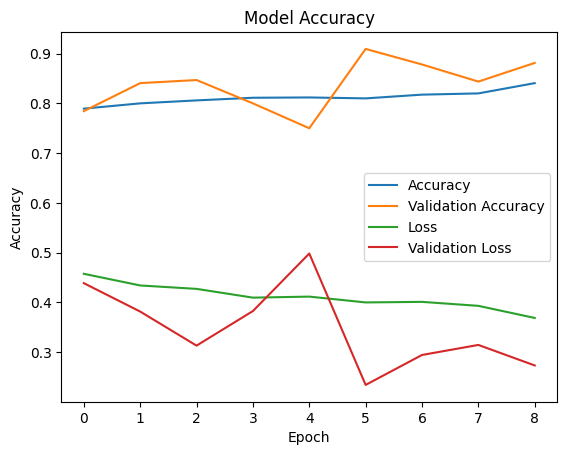

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])


plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])


plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
dog


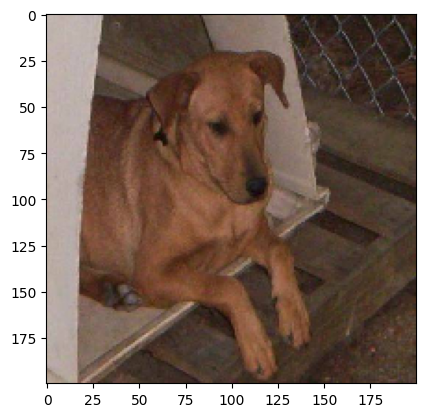

In [ ]:
from keras.preprocessing import image
from keras.models import load_model

img = image.load_img('../data/organized_dataset/train/dog/dog.100.jpg' , target_size = (200, 200))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis = 0)
saved_model = load_model("../models/best_simplified_model.keras")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("dog")
else:
    print("cat")